In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nn import Layer, FeedForwardNN, WeightInitializationOption, WeightInitializer, Activation, xavier_std
from optimizers import RMSProp, StochasticGradientDescent
from metrics import mean_squared_error_loss
from sklearn.model_selection import train_test_split


# Universal Function Approximation

In [10]:
class FuncApproximator:
    """
    A class to approximate a scalar function using a FeedForward Neural Network.

    Attributes:
        model (FeedForwardNN): The neural network model to be trained.
        scalar_func (callable): The function to be approximated.
        x (np.ndarray): The input data points.
        y (np.ndarray): The output data points corresponding to x.
    """

    def __init__(self, model: FeedForwardNN, scalar_func: callable, x: np.ndarray, y: np.ndarray):
        """
        Initializes the FuncApproximator.

        Args:
            model (FeedForwardNN): An instance of the FeedForwardNN class.
            scalar_func (callable): The scalar function to approximate.
            x (np.ndarray): An array of input values.
            y (np.ndarray): An array of output values from the scalar_func.
        """
        self.model = model
        self.scalar_func = scalar_func
        self.x = x
        self.y = y
        self.y_pred = None  # To store predictions after fitting

    def fit(self, batch_size: int, test_split_size: float, epochs: int, display_on_each_n_step: int, learning_rate: float = 0.001):
        """
        Trains the neural network model to approximate the function.

        Args:
            batch_size (int): The number of samples per batch.
            test_split_size (float): The proportion of the dataset to include in the validation split.
            epochs (int): The number of epochs to train for.
            display_on_each_n_step (int): How often to display training progress.
            learning_rate (float, optional): The learning rate for the optimizer. Defaults to 0.001.
        """
        # Reshape data for train_test_split
        X_data_reshaped = self.x.reshape(-1, 1)

        # Split data into training and validation sets
        X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
            X_data_reshaped, self.y, test_size=test_split_size, random_state=42
        )

        # Convert to list of lists for X and list for y, as expected by FeedForwardNN
        X_train = X_train_np.tolist()
        y_train = y_train_np.tolist()
        X_val = X_val_np.tolist()
        y_val = y_val_np.tolist()

        # Choose Optimizer and Loss
        params = self.model.parameters()
        optimizer = RMSProp(parameters=params, lr=learning_rate, beta=0.95)
        loss_fn = mean_squared_error_loss

        # Fit the model
        self.model.fit(
            X_train=X_train,
            y_train=y_train,
            optimizer=optimizer,
            loss=loss_fn,
            epochs=epochs,
            batch_size=batch_size,
            metric="mse",
            X_val=X_val,
            y_val=y_val,
            display_each_n_step=display_on_each_n_step
        )
        
        # After fitting, we can generate the predictions for visualization
        self._predict_full_range()

    def _predict_full_range(self):
        """Helper method to predict y values for the entire range of x."""
        X_full_for_prediction = [[val] for val in self.x]
        y_pred_values_nested = self.model.forward_batch(x=X_full_for_prediction)
        
        # Extract the scalar value from the output
        self.y_pred = np.array([val[0].val for val in y_pred_values_nested])


    def visualize_fit(self):
        """
        Visualizes the original function and the neural network's approximation.
        """
        if self.y_pred is None:
            print("Model has not been fitted yet. Please call the 'fit' method first.")
            return

        plt.figure(figsize=(12, 7))
        plt.plot(self.x, self.y, label='True Function', color='blue', linewidth=2)
        plt.plot(self.x, self.y_pred, label='NN Approximation', color='red', linestyle='--', alpha=0.7)
        plt.title('Neural Network Approximation of a Function')
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.grid(True)
        plt.legend(fontsize=12)
        plt.axhline(0, color='black', linewidth=0.5)
        plt.axvline(0, color='black', linewidth=0.5)
        plt.show()

## Approximate Function 1

**Let's use Multilayer Perceptron to learn approximation for this function on interval $[0, 15]$**

$f(x) = -0.03 \cdot x^2 \cdot 0.05 \cdot \ln(x^3) + 0.5 \cdot \cos\left(\frac{x}{1.5}\right) + 0.1 \cdot \sin(5x)$


2025-07-16 22:01:18.324 | INFO     | nn:fit:428 - Epoch 1/60  train_loss=1.2080  mse: 1.2080069535865048    val_loss=0.4797  val_mse=0.4797
2025-07-16 22:01:23.201 | INFO     | nn:fit:428 - Epoch 5/60  train_loss=0.6383  mse: 0.638338430048865    val_loss=0.2752  val_mse=0.2752
2025-07-16 22:01:29.098 | INFO     | nn:fit:428 - Epoch 10/60  train_loss=0.4515  mse: 0.4514537564472733    val_loss=0.1896  val_mse=0.1896
2025-07-16 22:01:35.334 | INFO     | nn:fit:428 - Epoch 15/60  train_loss=0.3580  mse: 0.35799895604635645    val_loss=0.1765  val_mse=0.1765
2025-07-16 22:01:41.620 | INFO     | nn:fit:428 - Epoch 20/60  train_loss=0.2634  mse: 0.2634007489225476    val_loss=0.0896  val_mse=0.0896
2025-07-16 22:01:48.461 | INFO     | nn:fit:428 - Epoch 25/60  train_loss=0.1789  mse: 0.1788640263055267    val_loss=0.1140  val_mse=0.1140
2025-07-16 22:01:54.460 | INFO     | nn:fit:428 - Epoch 30/60  train_loss=0.1609  mse: 0.1608507421084724    val_loss=0.0693  val_mse=0.0693
2025-07-16 22:0

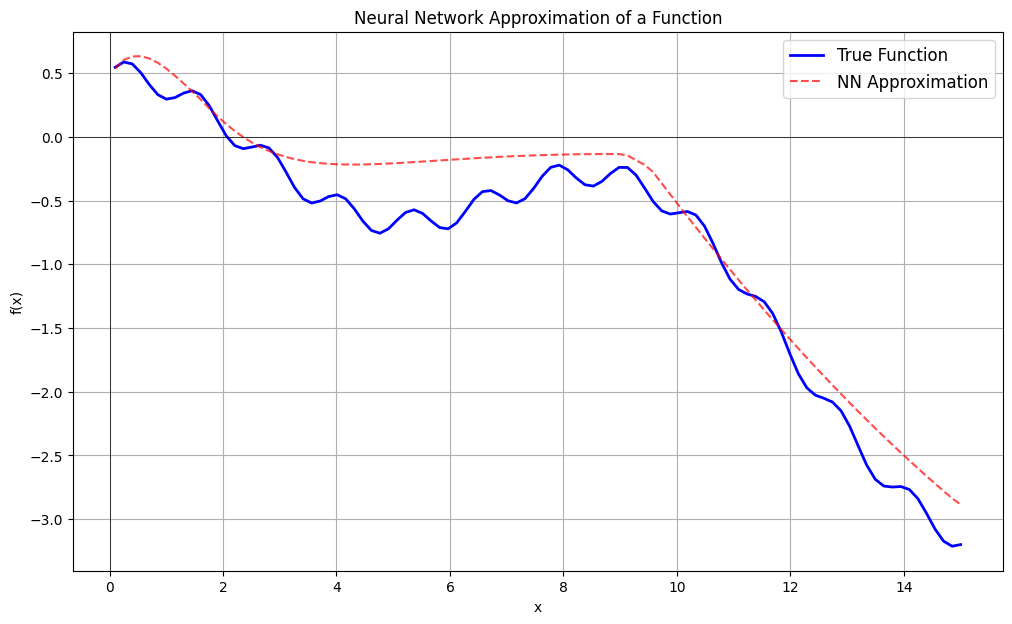

In [11]:
def complicated_function(x):
    return -0.03 * x**2  * 0.05 * np.log(x ** 3) + 0.5 * np.cos(x/1.5) + 0.1 * np.sin(x*5)

x_values = np.linspace(0.1, 15, 100)
y_values = complicated_function(x_values)

model = FeedForwardNN(
    layers=[
        Layer(
            n_input=1,
            n_output=24, 
            activation=Activation.TANH,
            initializer=WeightInitializer(option=WeightInitializationOption.NORMAL, sd=xavier_std(1, 16))
        ),
        Layer(
            n_input=24,
            n_output=8, 
            activation=Activation.RELU,
            initializer=WeightInitializer(option=WeightInitializationOption.NORMAL, sd=xavier_std(16, 8))
        ),
        Layer(
            n_input=8,
            n_output=8, 
            activation=Activation.RELU,
            initializer=WeightInitializer(option=WeightInitializationOption.NORMAL, sd=xavier_std(8, 8))
        ),
        Layer(
            n_input=8,
            n_output=1, 
            activation=Activation.LINEAR,
            initializer=WeightInitializer(option=WeightInitializationOption.NORMAL, sd=xavier_std(8, 1))
        )
    ]
)

approximator1 = FuncApproximator(
    model=model,
    scalar_func=complicated_function,
    x=x_values,
    y=y_values
)
approximator1.fit(
    batch_size=8,
    test_split_size=0.1,
    epochs=60,
    display_on_each_n_step=5,
    learning_rate=0.0025
)
approximator1.visualize_fit()

## Approximate Function 2


In [ ]:
def dampened_wave_function_2(x):
    """
    A function that represents a dampened wave.
    """
    return np.exp(-0.5 * x) * np.sin(x * 2)

x_values_2 = np.linspace(0, 10, 200)  # Using more points for a smoother curve
y_values_2 = dampened_wave_function_2(x_values_2)

model_2 = FeedForwardNN(
    layers=[
        Layer(
            n_input=1,
            n_output=32,  # Increased neurons for more complexity
            activation=Activation.TANH,
            initializer=WeightInitializer(option=WeightInitializationOption.NORMAL, sd=xavier_std(1, 32))
        ),
        Layer(
            n_input=32,
            n_output=16,
            activation=Activation.RELU,
            initializer=WeightInitializer(option=WeightInitializationOption.NORMAL, sd=xavier_std(32, 16))
        ),
        Layer(
            n_input=16,
            n_output=16,
            activation=Activation.RELU,
            initializer=WeightInitializer(option=WeightInitializationOption.NORMAL, sd=xavier_std(16, 16))
        ),
        Layer(
            n_input=16,
            n_output=1,
            activation=Activation.LINEAR,
            initializer=WeightInitializer(option=WeightInitializationOption.NORMAL, sd=xavier_std(16, 1))
        )
    ]
)

approximator2 = FuncApproximator(
    model=model_2,
    scalar_func=dampened_wave_function_2,
    x=x_values_2,
    y=y_values_2
)

approximator2.fit(
    batch_size=4,
    test_split_size=0.15,
    epochs=80,  # Increased epochs for better fitting
    display_on_each_n_step=5,
    learning_rate=0.0008
)

approximator2.visualize_fit()

                                   2025-07-16 22:20:37.641 | INFO     | nn:fit:428 - Epoch 1/80  train_loss=0.0625  mse: 0.06250194220488597    val_loss=0.0392  val_mse=0.0392
2025-07-16 22:21:06.267 | INFO     | nn:fit:428 - Epoch 5/80  train_loss=0.0174  mse: 0.017417452356413808    val_loss=0.0239  val_mse=0.0239
2025-07-16 22:21:46.856 | INFO     | nn:fit:428 - Epoch 10/80  train_loss=0.0148  mse: 0.014750100448583024    val_loss=0.0109  val_mse=0.0109
2025-07-16 22:22:28.407 | INFO     | nn:fit:428 - Epoch 15/80  train_loss=0.0143  mse: 0.014262082462608449    val_loss=0.0128  val_mse=0.0128
2025-07-16 22:23:09.023 | INFO     | nn:fit:428 - Epoch 20/80  train_loss=0.0135  mse: 0.013489406072590868    val_loss=0.0120  val_mse=0.0120
                                    2025-07-16 22:23:50.847 | INFO     | nn:fit:428 - Epoch 25/80  train_loss=0.0117  mse: 0.011737207604773559    val_loss=0.0153  val_mse=0.0153
2025-07-16 22:24:29.470 | INFO     | nn:fit:428 - Epoch 30/80  train_loss=